In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
from numpy.linalg import inv
import seaborn as sns
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

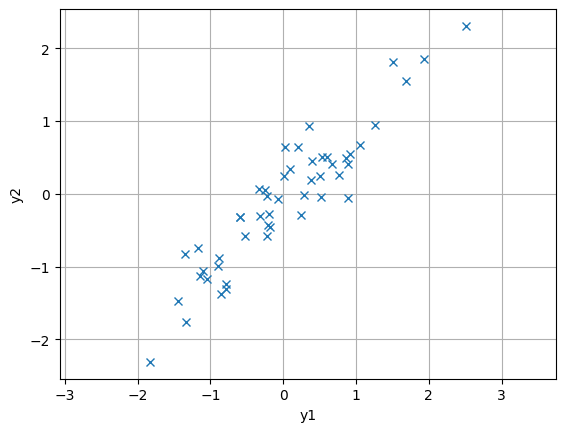

In [3]:
c = 0.9
n=50
K = np.array([[1,c], [c,1]])

samples = np.random.multivariate_normal([0, 0], K, size=n)

plt.plot(samples[:, 0], samples[:, 1], 'x')
plt.xlabel('y1')
plt.ylabel('y2')
plt.axis('equal')
plt.grid()
plt.show()

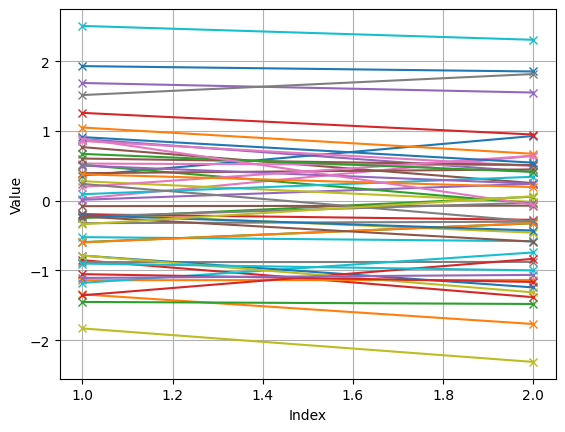

In [4]:
for i in range(n):
    plt.plot([1, 2], [samples[i, 0], samples[i, 1]], '-x')

plt.xlabel('Index')
plt.ylabel('Value')
plt.grid()
plt.show()

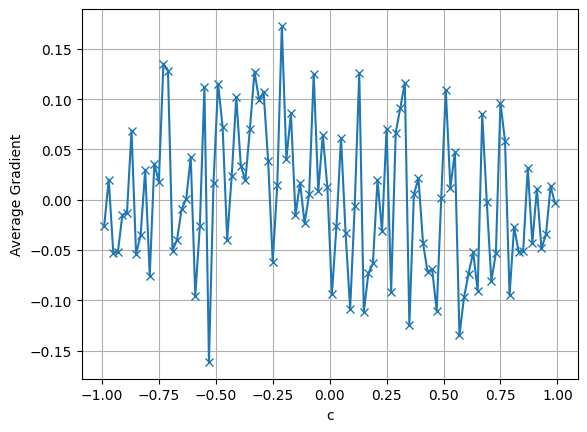

In [5]:
def average_gradient(c, n=100):
    K = np.array([[1, c], [c, 1]])
    samples = np.random.multivariate_normal([0, 0], K, size=n)
    gradient = abs(samples[:, 1]) - abs(samples[:, 0])
    return np.mean(gradient)

c_values = np.linspace(-0.99, 0.99, 100)
avg_gradient = [average_gradient(c) for c in c_values]

plt.plot(c_values, avg_gradient, '-x')
plt.xlabel('c')
plt.ylabel('Average Gradient')
plt.grid()
plt.show()


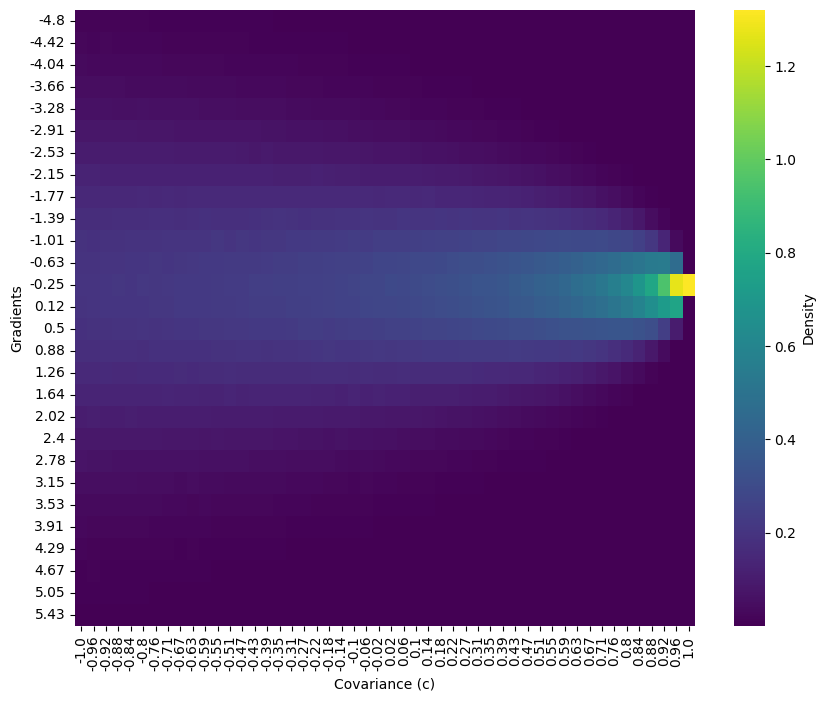

In [7]:
def gradients_for_c(c, n=100000):
    K = np.array([[1, c], [c, 1]])
    samples = np.random.multivariate_normal([0, 0], K, size=n)
    return ((samples[:, 1]) - (samples[:, 0]))

c_values = np.linspace(-1.00, 1.00, 50)
gradients = np.array([gradients_for_c(c) for c in c_values])

gradient_bins = np.linspace(gradients.min(), gradients.max(), 50)
heatmap_data = np.zeros((len(c_values), len(gradient_bins)-1))

for i, c in enumerate(c_values):
    heatmap_data[i], _ = np.histogram(gradients[i], bins=gradient_bins, density=True)

heatmap_data = heatmap_data.T

min_density = np.min(heatmap_data[np.nonzero(heatmap_data)])
max_density = np.max(heatmap_data)

percentile_25 = np.percentile(gradients, 0.1)
percentile_75 = np.percentile(gradients, 99.9)

y_min_index = np.searchsorted(gradient_bins, percentile_25)
y_max_index = np.searchsorted(gradient_bins, percentile_75)

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data[y_min_index:y_max_index+1],
            xticklabels=np.round(c_values, 2),
            yticklabels=np.round(gradient_bins[y_min_index:y_max_index+1], 2),
            cmap='viridis', vmin=min_density, vmax=max_density*0.5,
            cbar_kws={'label': 'Density'})
plt.xlabel('Covariance (c)')
plt.ylabel('Gradients')
plt.show()


In [8]:
def kSE(xm, xn, sigma_f=0.5, l=1.0):
    return sigma_f**2 * np.exp(-0.5 * (np.linalg.norm(xm - xn)**2) / l**2)

def kOU(xm, xn, sigma_f=0.5, l=1.0):
    return sigma_f**2 * np.exp(-np.linalg.norm(xm - xn) / l)

def kosc(xm, xn, sigma_f=0.5, l=1.0, A=1.0, P=np.pi):
    return sigma_f**2 * np.exp(-A * np.sin(np.pi * np.linalg.norm(xm - xn) / P)**2 - (np.linalg.norm(xm - xn)**2) / (2 * l**2))

def klin(xm, xn, sigma_f=0.5, c=0):
    return sigma_f**2 * (xm - c) * (xn - c)

def covariance_matrix(points, sigma_d=0.0, kernel='se', **kwargs):
    kernels = {
        'se': kSE,
        'ou': kOU,
        'osc': kosc,
        'lin': klin
    }
    kernel_func = kernels[kernel]
    N = len(points)
    K = np.zeros((N, N))
    for m in range(N):
        for n in range(N):
            K[m, n] = kernel_func(points[m], points[n], **kwargs)
            if m == n:
                K[m, n] += sigma_d**2
    return K

def visualize_covariance_matrix(K):
    plt.figure(figsize=(10, 8))
    plt.imshow(K)
    plt.xlabel('Index of x')
    plt.ylabel('Index of x')
    plt.show()

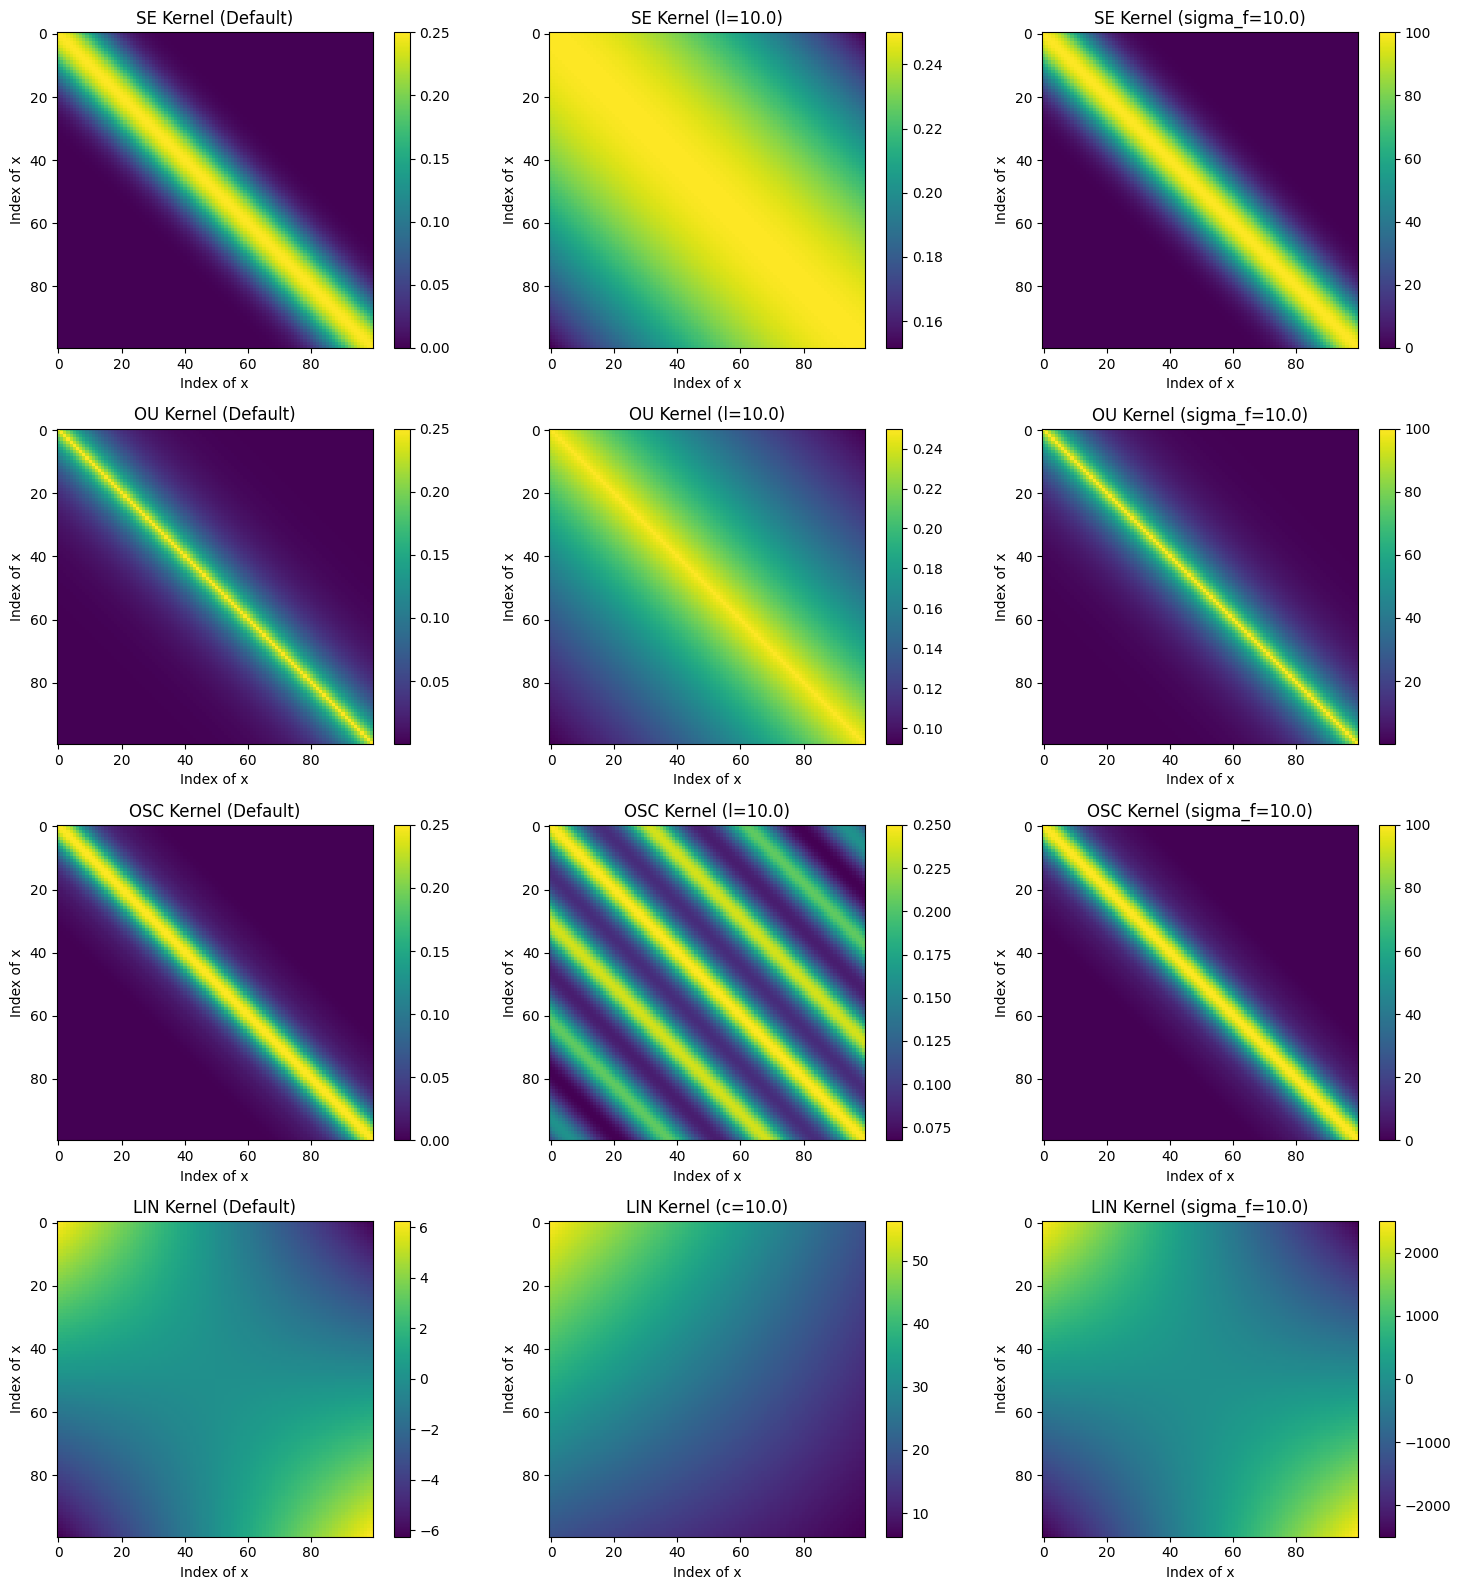

In [9]:
points = np.linspace(-5, 5, 100)

cov_matrices = {}
for kernel in ['se', 'ou', 'osc', 'lin']:
    cov_matrices[kernel] = covariance_matrix(points, kernel=kernel)

adjusted_variations = {
    'se': [{}, {'l': 10.0}, {'sigma_f': 10.0}],
    'ou': [{}, {'l': 10.0}, {'sigma_f': 10.0}],
    'osc': [{}, {'l': 10.0}, {'sigma_f': 10.0}],
    'lin': [{}, {'c': 10.0}, {'sigma_f': 10.0}]
}

fig, axs = plt.subplots(4, 3, figsize=(15, 16))

for i, kernel in enumerate(adjusted_variations.keys()):
    for j, params in enumerate(adjusted_variations[kernel]):
        K_var = covariance_matrix(points, kernel=kernel, **params)
        ax = axs[i, j]
        cax = ax.imshow(K_var)
        param_str = ', '.join([f'{k}={v}' for k, v in params.items()]) if params else 'Default'
        fig.colorbar(cax, ax=ax)
        ax.set_title(f'{kernel.upper()} Kernel ({param_str})')
        ax.set_xlabel('Index of x')
        ax.set_ylabel('Index of x')

plt.tight_layout()
plt.show()



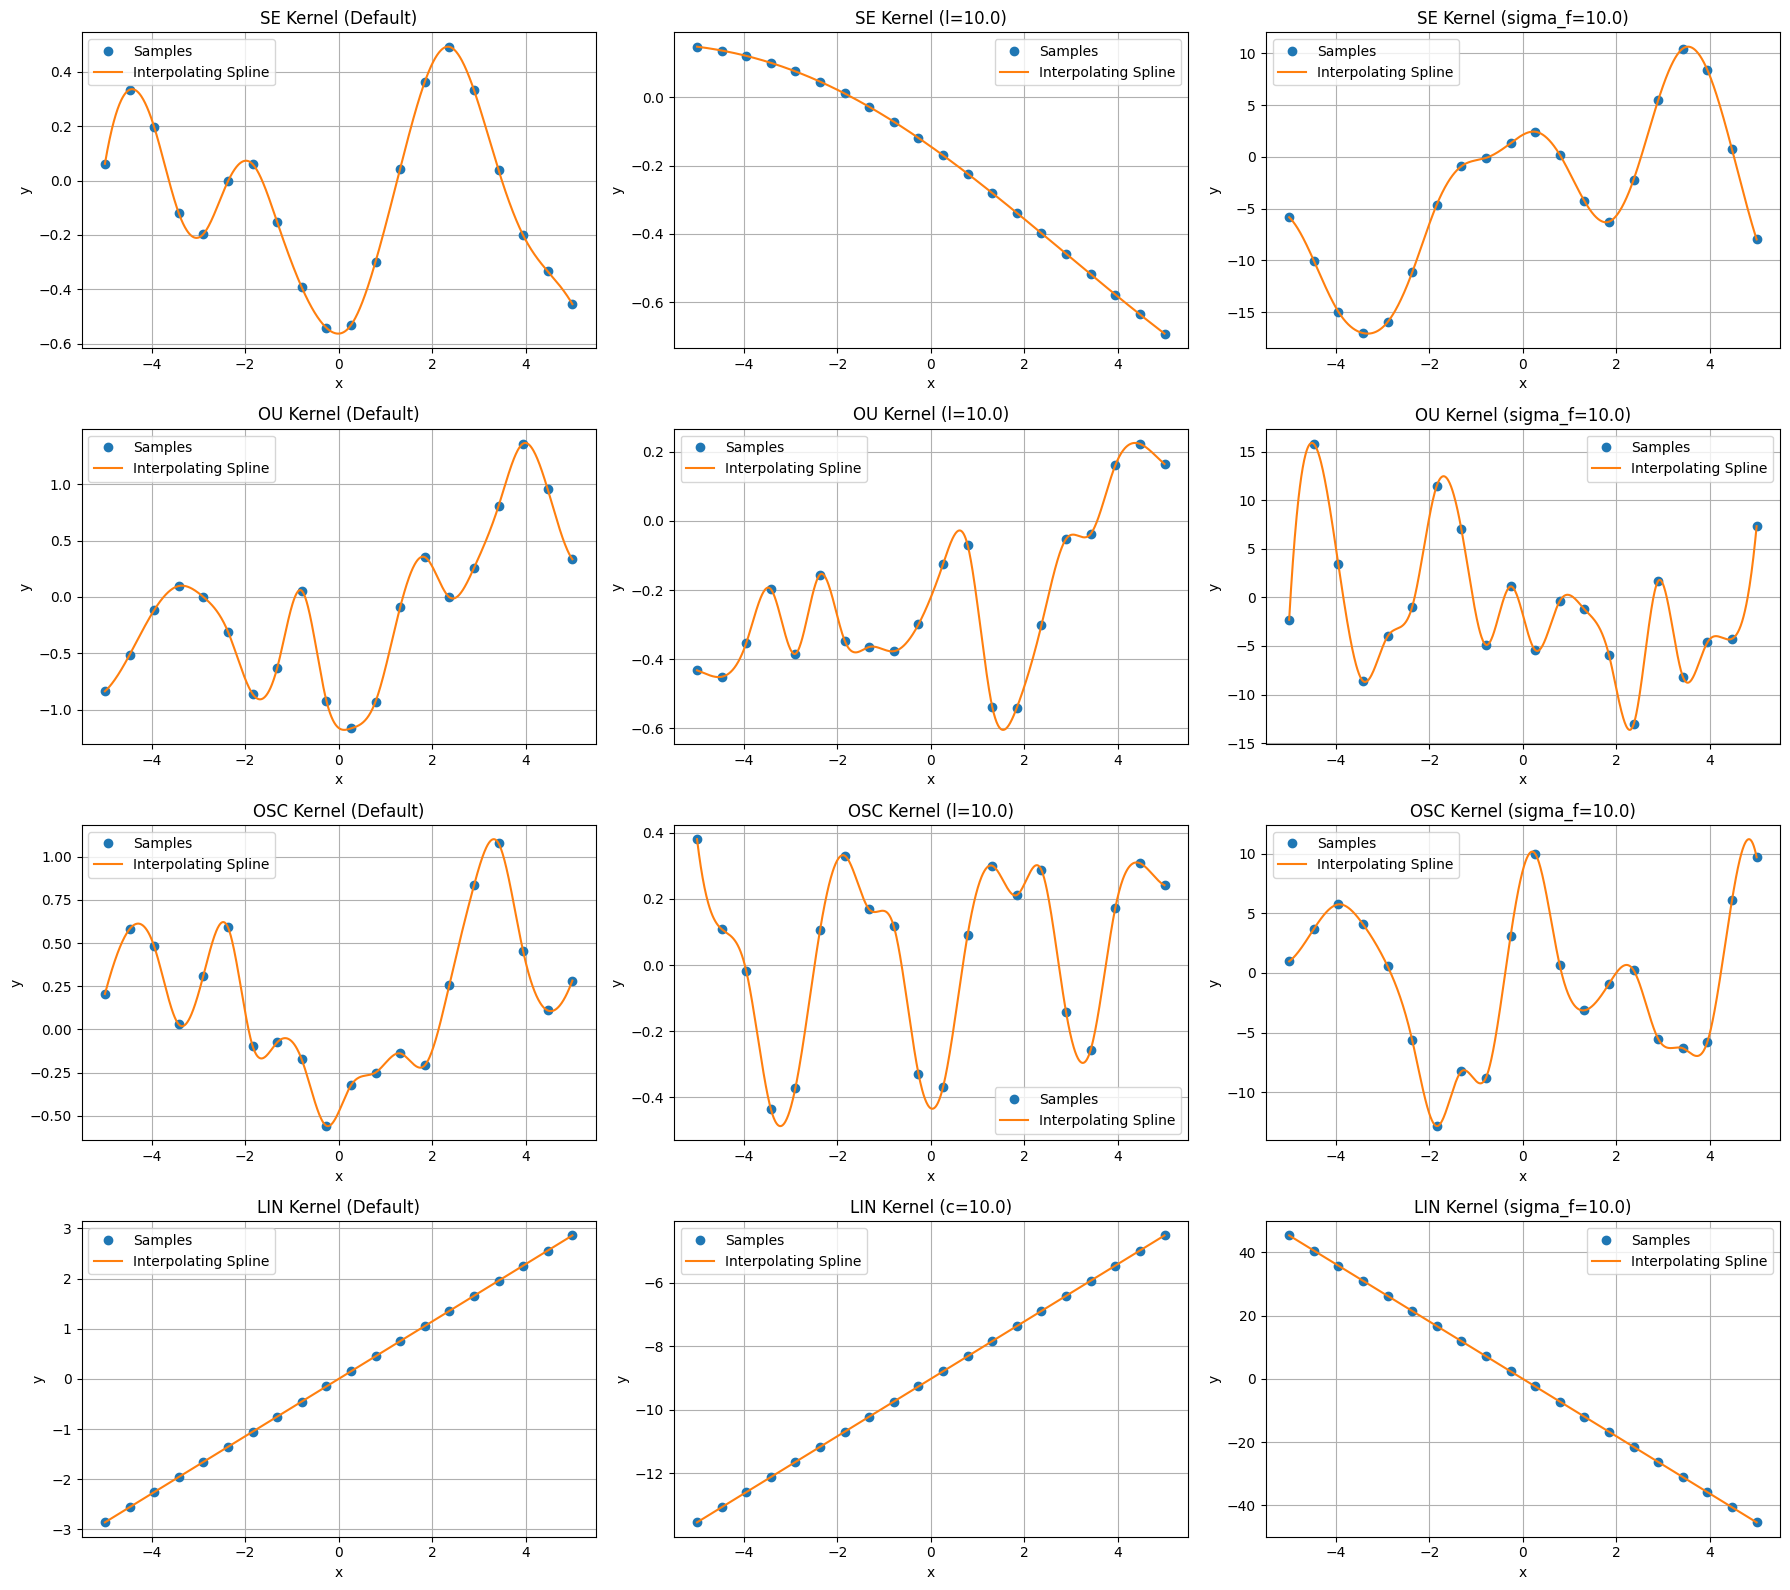

In [11]:
l_variation = 10.0
sigma_f_variation = 10.0
c_variation = 10.0
adjusted_variations = {
    'se': [{}, {'l': l_variation}, {'sigma_f': sigma_f_variation}],
    'ou': [{}, {'l': l_variation}, {'sigma_f': sigma_f_variation}],
    'osc': [{}, {'l': l_variation}, {'sigma_f': sigma_f_variation}],
    'lin': [{}, {'c': c_variation}, {'sigma_f': sigma_f_variation}]
}

def plot_samples_with_spline(ax, sorted_points, K, title):
    y_samples = np.random.multivariate_normal(np.zeros(len(sorted_points)), K)
    spline = InterpolatedUnivariateSpline(sorted_points, y_samples)
    xs = np.linspace(sorted_points.min(), sorted_points.max(), 1000)
    ys = spline(xs)

    ax.plot(sorted_points, y_samples, 'o', label='Samples')
    ax.plot(xs, ys, label='Interpolating Spline')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

uniform_sample_points = np.linspace(-5, 5, 20)

fig, axs = plt.subplots(4, 3, figsize=(18, 16))

for i, (kernel, variations) in enumerate(adjusted_variations.items()):
    for j, params in enumerate(variations):
        K_var = covariance_matrix(uniform_sample_points, kernel=kernel, **params, sigma_d = 0)
        ax = axs[i, j]
        plot_samples_with_spline(ax, uniform_sample_points, K_var, f"{kernel.upper()} Kernel ({', '.join(f'{k}={v}' for k, v in params.items() if v) if params else 'Default'})")

plt.tight_layout()
plt.show()




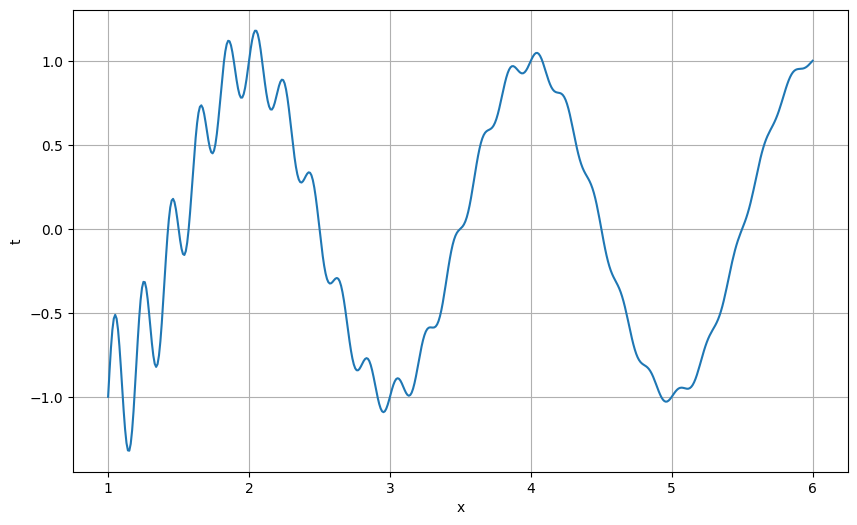

In [12]:
def f(x):
    return np.cos(x*np.pi) + np.sin(10*np.pi*x) / (1 + x**2)


a = 1
b = 6
n = 500
x = np.linspace(a, b, n)
t = f(x)
sigma_f = 1

plt.figure(figsize=(10, 6))
plt.plot(x, t)
plt.xlabel('x')
plt.ylabel('t')
plt.grid(True)
plt.show()

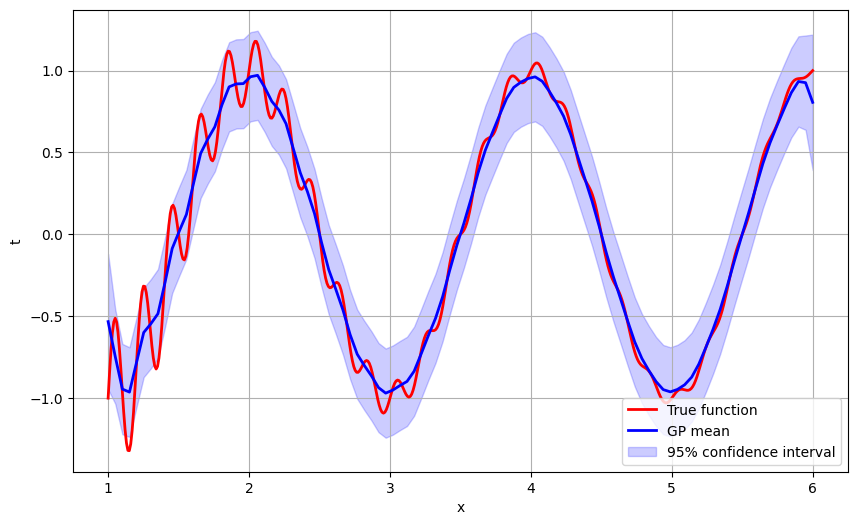

In [13]:
sigma_d = 0.5
sigma_f = 0.5
l = 0.1
m=100

def kSE(xm, xn, sigma_f=1.0, l=1.0):
    xm = np.atleast_2d(xm)
    xn = np.atleast_2d(xn)
    sqdist = np.sum(xm**2, axis=1).reshape(-1, 1) + np.sum(xn**2, axis=1) - 2 * np.dot(xm, xn.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

x_star = np.linspace(a, b, m).reshape(-1, 1)
x = x.reshape(-1, 1)

kernel_X_X = kSE(x, x, sigma_f, l)
kernel_X_star_X = kSE(x_star, x, sigma_f, l)
kernel_X_star_X_star = kSE(x_star, x_star, sigma_f, l)
kernel_X_X_star = kSE(x, x_star, sigma_f, l)

mu_t_star = np.dot(kernel_X_star_X, inv(kernel_X_X + sigma_d**2 * np.eye(n)).dot(t)).flatten()
Sigma_t_star = kernel_X_star_X_star - np.dot(kernel_X_star_X, inv(kernel_X_X + sigma_d**2 * np.eye(n)).dot(kernel_X_X_star))
std_t_star = np.sqrt(np.diag(Sigma_t_star))

plt.figure(figsize=(10, 6))
plt.plot(x, t, 'r', lw=2, label='True function')
plt.plot(x_star, mu_t_star, 'b', lw=2, label='GP mean')
plt.fill_between(x_star.flatten(),
                 (mu_t_star - 1.96 * std_t_star).flatten(),
                 (mu_t_star + 1.96 * std_t_star).flatten(),
                 color='blue', alpha=0.2, label='95% confidence interval')
plt.xlabel('x')
plt.ylabel('t')
plt.grid(True)
plt.legend()
plt.show()


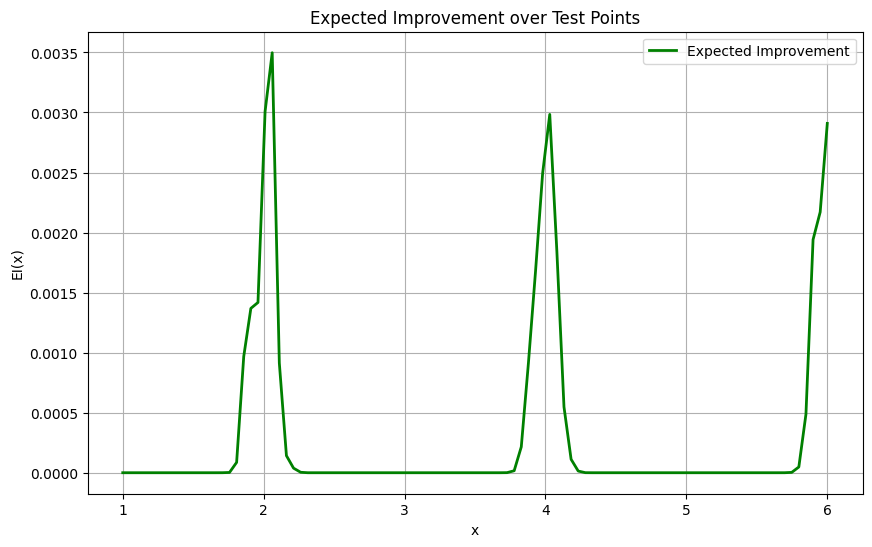

In [14]:
eta = np.max(t)

def expected_improvement(mu, sigma, eta, xi=0.01):
    with np.errstate(divide='warn', invalid='ignore'):
        imp = mu - eta - xi
        Z = np.divide(imp, sigma, out=np.zeros_like(sigma), where=sigma!=0)
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
        return ei

ei = expected_improvement(mu_t_star, std_t_star, eta)

plt.figure(figsize=(10, 6))
plt.plot(x_star.flatten(), ei, 'g-', lw=2, label='Expected Improvement')
plt.xlabel('x')
plt.ylabel('EI(x)')
plt.title('Expected Improvement over Test Points')
plt.grid(True)
plt.legend()
plt.show()

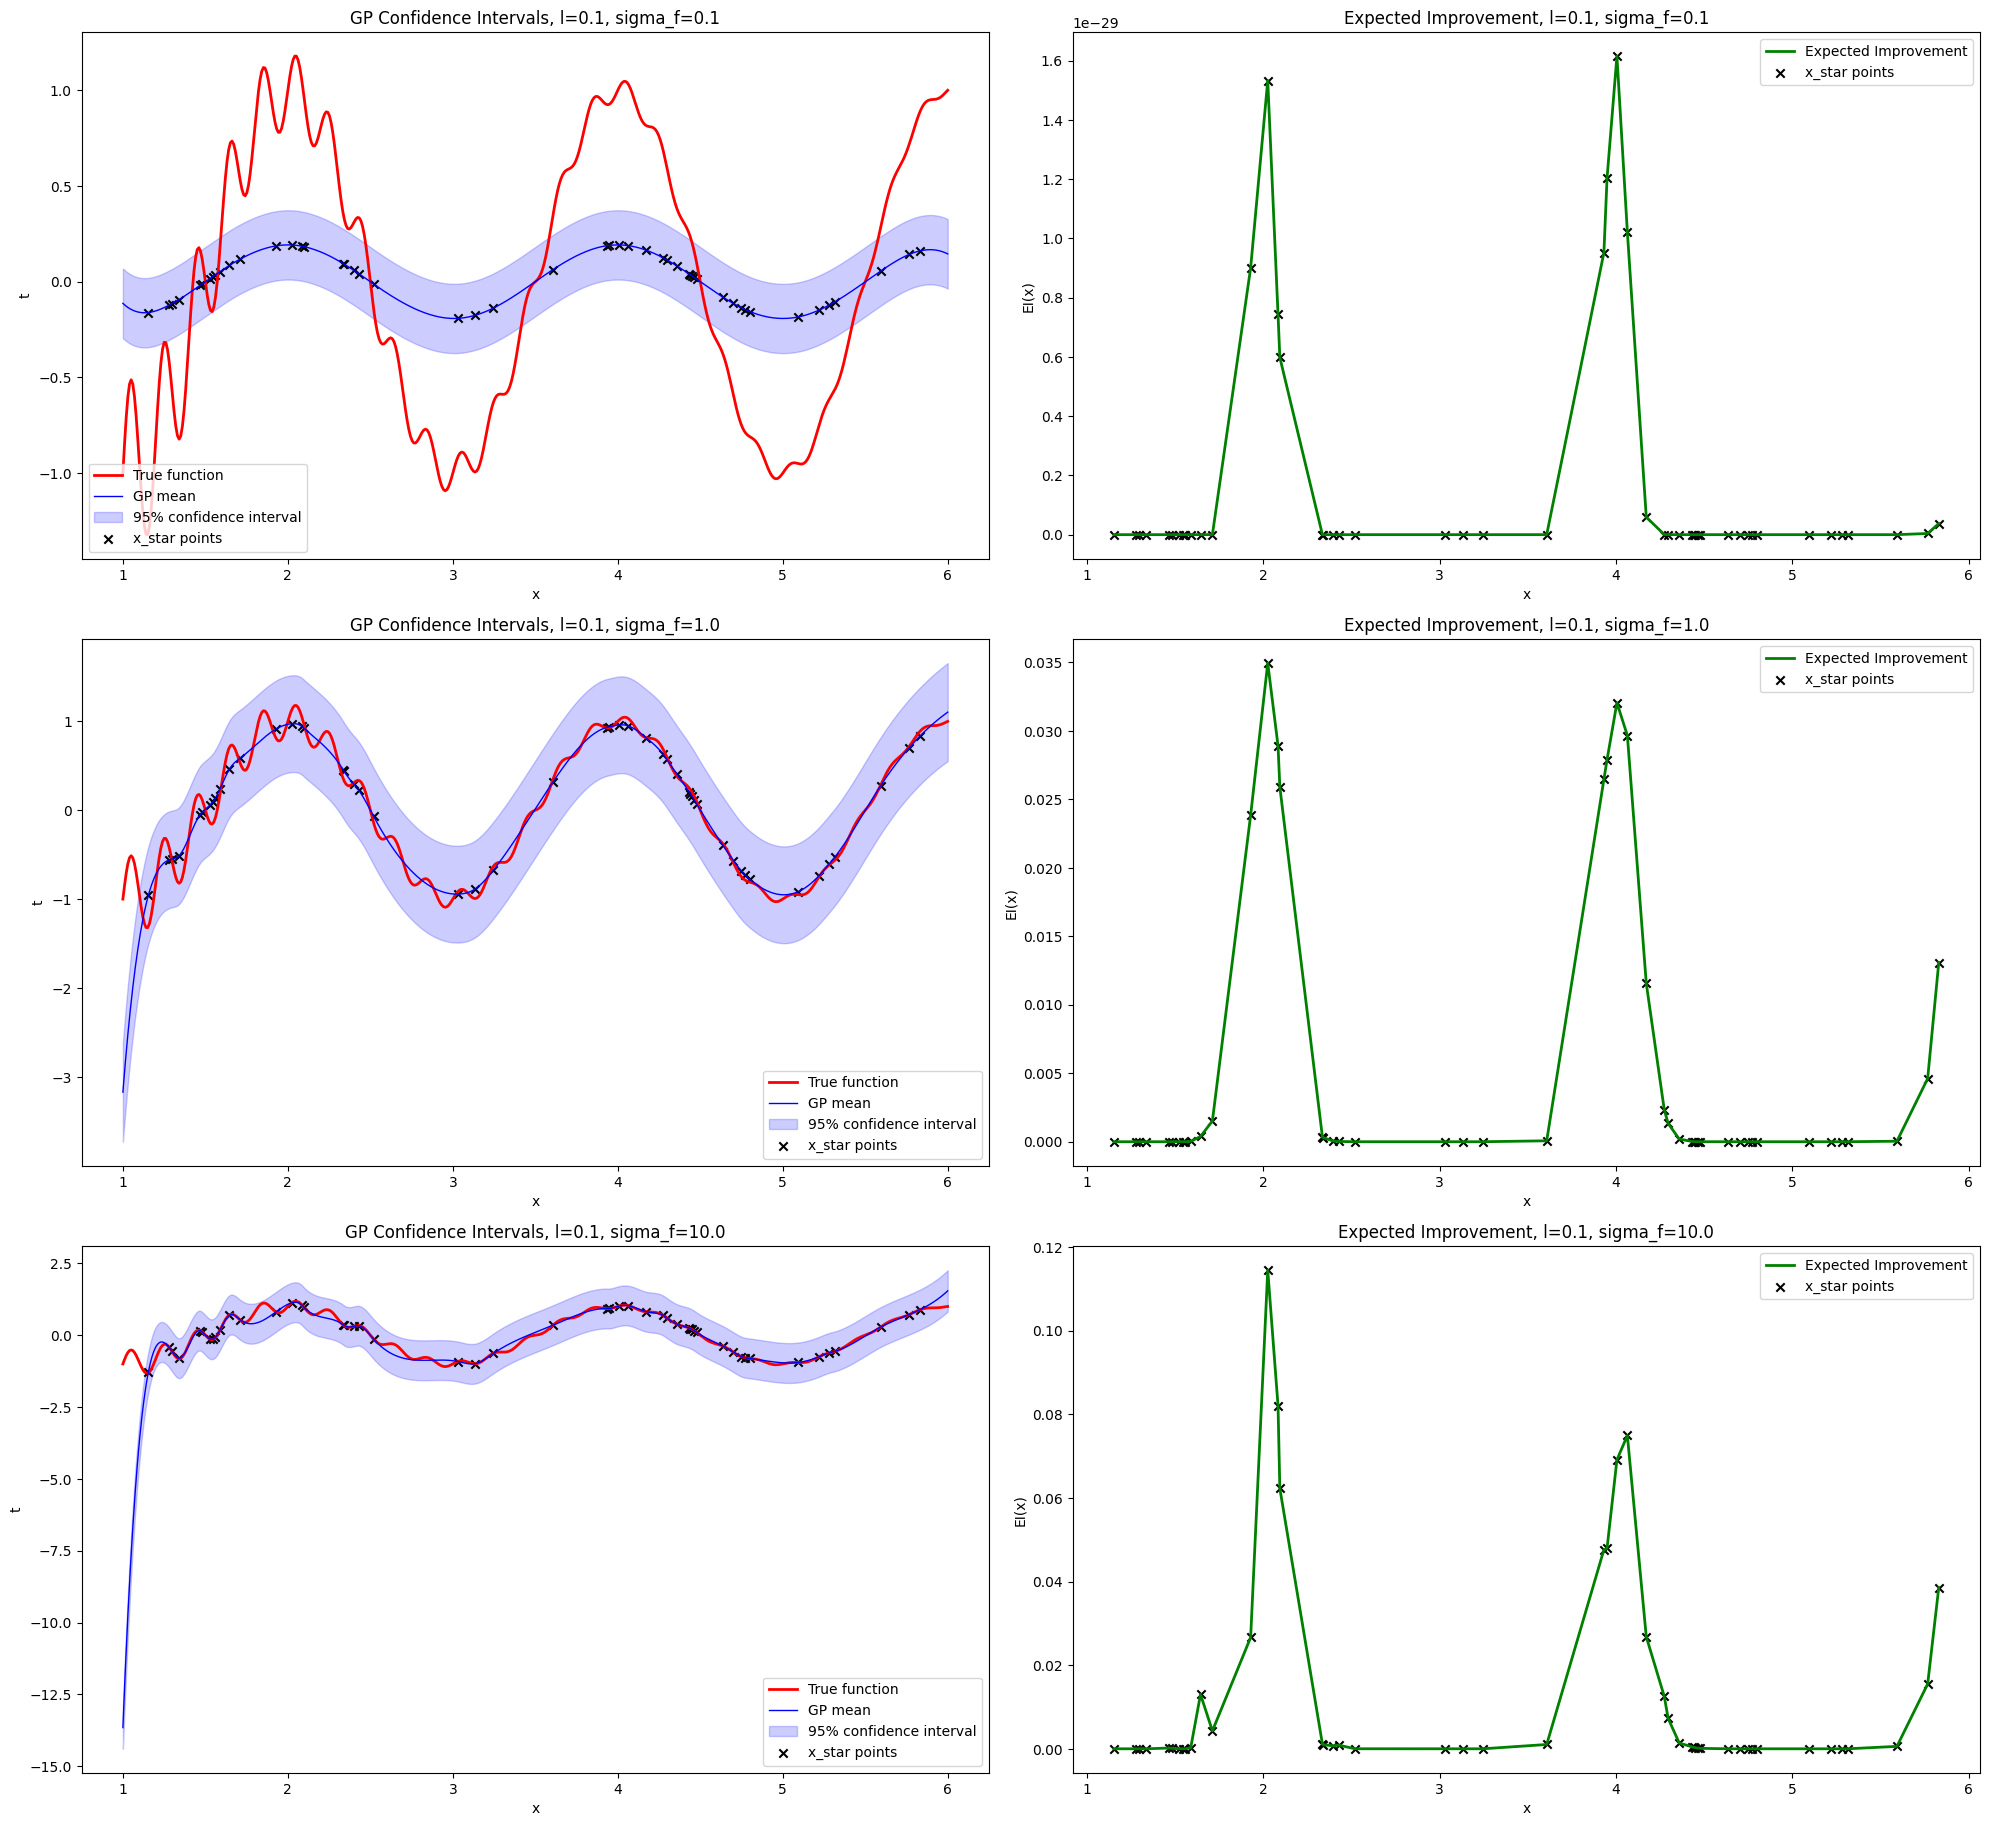

In [15]:
x = np.linspace(a, b, n).reshape(-1, 1)
x_star = np.random.uniform(a, b, 50).reshape(-1, 1)
x_star = np.sort(x_star, axis=0)
t = f(x.flatten())

sigma_d = 1.0
params = [(0.1, 0.1), (0.1, 1.0), (0.1, 10.0)]

plt.figure(figsize=(20, 24))

for i, (l, sigma_f) in enumerate(params):
    kernel_X_X = kSE(x, x, sigma_f, l)
    kernel_X_star_X = kSE(x_star, x, sigma_f, l)
    kernel_X_star_X_star = kSE(x_star, x_star, sigma_f, l)
    kernel_X_X_star = kSE(x, x_star, sigma_f, l)

    mu_t_star = np.dot(kernel_X_star_X, inv(kernel_X_X + sigma_d**2 * np.eye(n)).dot(t)).flatten()
    Sigma_t_star = kernel_X_star_X_star - np.dot(kernel_X_star_X, inv(kernel_X_X + sigma_d**2 * np.eye(n)).dot(kernel_X_X_star))
    std_t_star = np.sqrt(np.diag(Sigma_t_star))

    spline_mu = InterpolatedUnivariateSpline(x_star.flatten(), mu_t_star)
    upper_bound = mu_t_star + 1.96 * std_t_star
    lower_bound = mu_t_star - 1.96 * std_t_star
    spline_upper = InterpolatedUnivariateSpline(x_star.flatten(), upper_bound)
    spline_lower = InterpolatedUnivariateSpline(x_star.flatten(), lower_bound)

    xs = np.linspace(a, b, 1000)

    plt.subplot(4, 2, 2*i + 1)
    plt.plot(x, t, 'r', lw=2, label='True function')
    plt.plot(xs, spline_mu(xs), 'b', lw=1, label='GP mean')
    plt.fill_between(xs, spline_lower(xs), spline_upper(xs), color='blue', alpha=0.2, label='95% confidence interval')
    plt.scatter(x_star, mu_t_star, c='k', marker='x', label='x_star points')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title(f'GP Confidence Intervals, l={l}, sigma_f={sigma_f}')
    plt.legend()

    eta = np.max(t)
    ei = expected_improvement(mu_t_star, std_t_star, eta)
    plt.subplot(4, 2, 2*i + 2)
    plt.plot(x_star.flatten(), ei, 'g-', lw=2, label='Expected Improvement')
    plt.scatter(x_star, ei, c='k', marker='x', label='x_star points')
    plt.xlabel('x')
    plt.ylabel('EI(x)')
    plt.title(f'Expected Improvement, l={l}, sigma_f={sigma_f}')
    plt.legend()

plt.tight_layout()
plt.show()



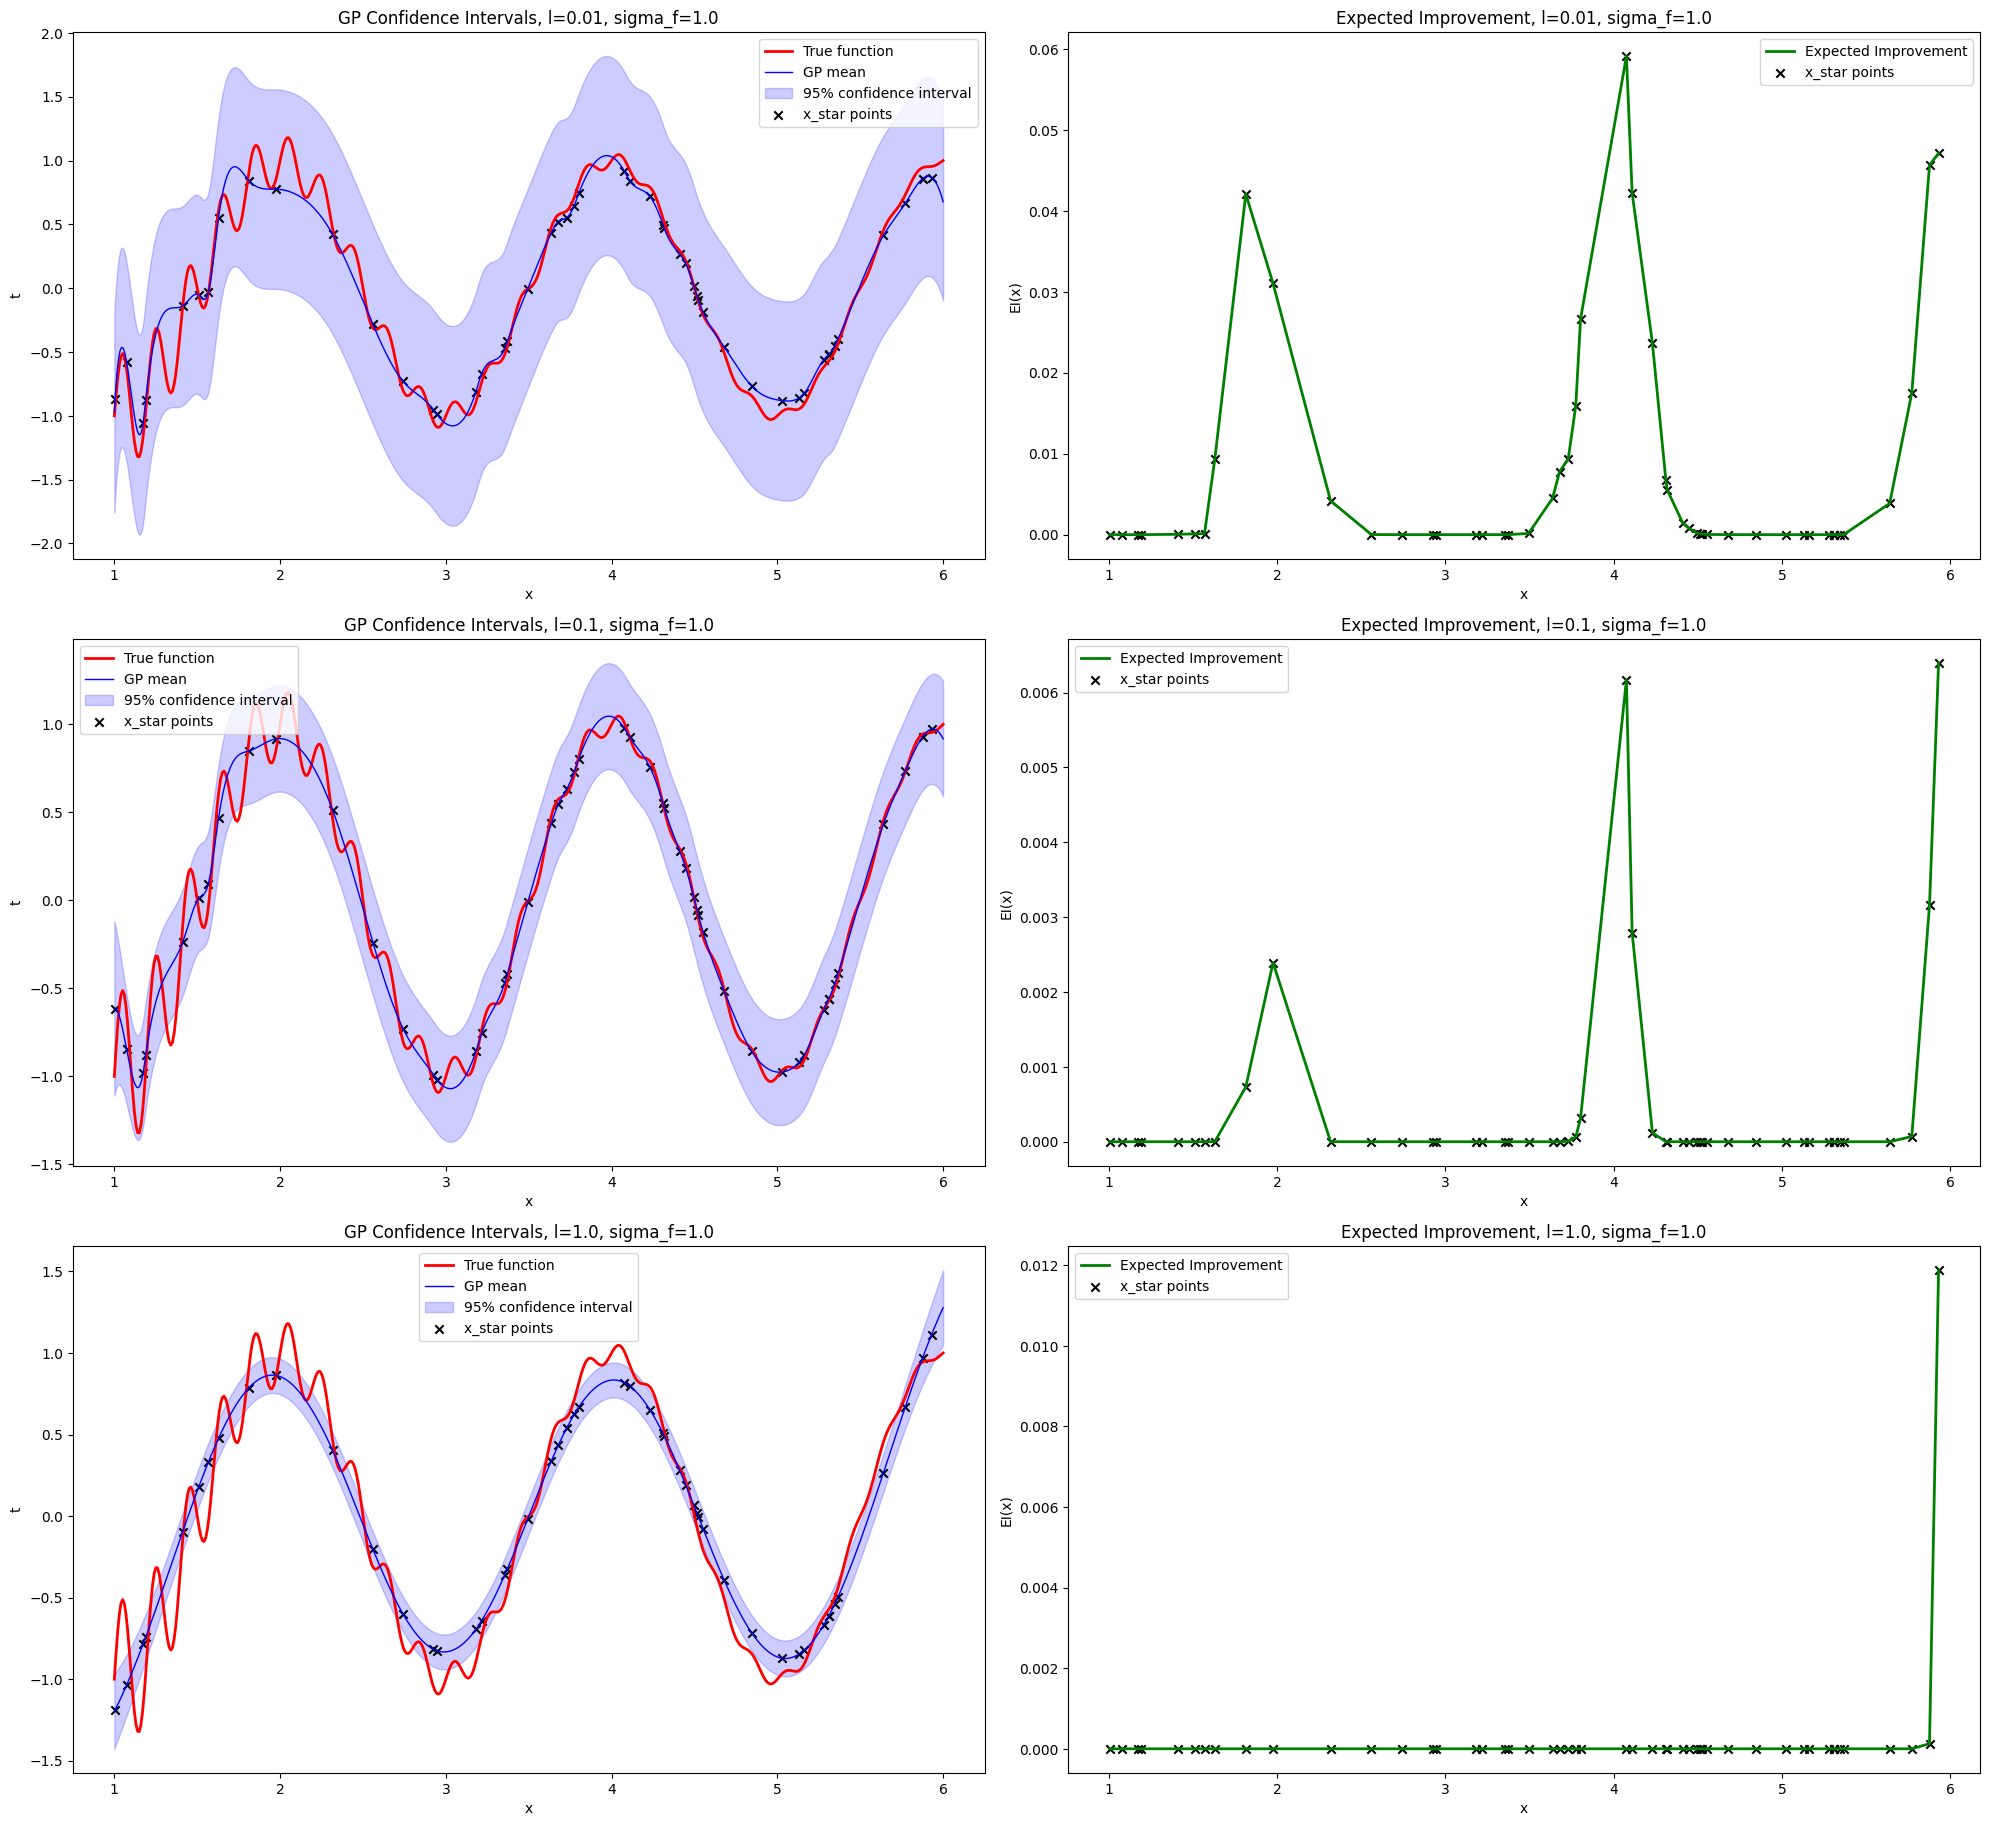

In [16]:
x = np.linspace(a, b, n).reshape(-1, 1)
x_star = np.random.uniform(a, b, 50).reshape(-1, 1)
x_star = np.sort(x_star, axis=0)
t = f(x.flatten())

sigma_d = 0.5
params = [(0.01, 1.0), (0.1, 1.0), (1.0, 1.0)]

plt.figure(figsize=(20, 24))

for i, (l, sigma_f) in enumerate(params):
    kernel_X_X = kSE(x, x, sigma_f, l)
    kernel_X_star_X = kSE(x_star, x, sigma_f, l)
    kernel_X_star_X_star = kSE(x_star, x_star, sigma_f, l)
    kernel_X_X_star = kSE(x, x_star, sigma_f, l)

    mu_t_star = np.dot(kernel_X_star_X, inv(kernel_X_X + sigma_d**2 * np.eye(n)).dot(t)).flatten()
    Sigma_t_star = kernel_X_star_X_star - np.dot(kernel_X_star_X, inv(kernel_X_X + sigma_d**2 * np.eye(n)).dot(kernel_X_X_star))
    std_t_star = np.sqrt(np.diag(Sigma_t_star))

    spline_mu = InterpolatedUnivariateSpline(x_star.flatten(), mu_t_star)
    upper_bound = mu_t_star + 1.96 * std_t_star
    lower_bound = mu_t_star - 1.96 * std_t_star
    spline_upper = InterpolatedUnivariateSpline(x_star.flatten(), upper_bound)
    spline_lower = InterpolatedUnivariateSpline(x_star.flatten(), lower_bound)

    xs = np.linspace(a, b, 1000)

    plt.subplot(4, 2, 2*i + 1)
    plt.plot(x, t, 'r', lw=2, label='True function')
    plt.plot(xs, spline_mu(xs), 'b', lw=1, label='GP mean')
    plt.fill_between(xs, spline_lower(xs), spline_upper(xs), color='blue', alpha=0.2, label='95% confidence interval')
    plt.scatter(x_star, mu_t_star, c='k', marker='x', label='x_star points')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title(f'GP Confidence Intervals, l={l}, sigma_f={sigma_f}')
    plt.legend()

    eta = np.max(t)
    ei = expected_improvement(mu_t_star, std_t_star, eta)
    plt.subplot(4, 2, 2*i + 2)
    plt.plot(x_star.flatten(), ei, 'g-', lw=2, label='Expected Improvement')
    plt.scatter(x_star, ei, c='k', marker='x', label='x_star points')
    plt.xlabel('x')
    plt.ylabel('EI(x)')
    plt.title(f'Expected Improvement, l={l}, sigma_f={sigma_f}')
    plt.legend()

plt.tight_layout()
plt.show()



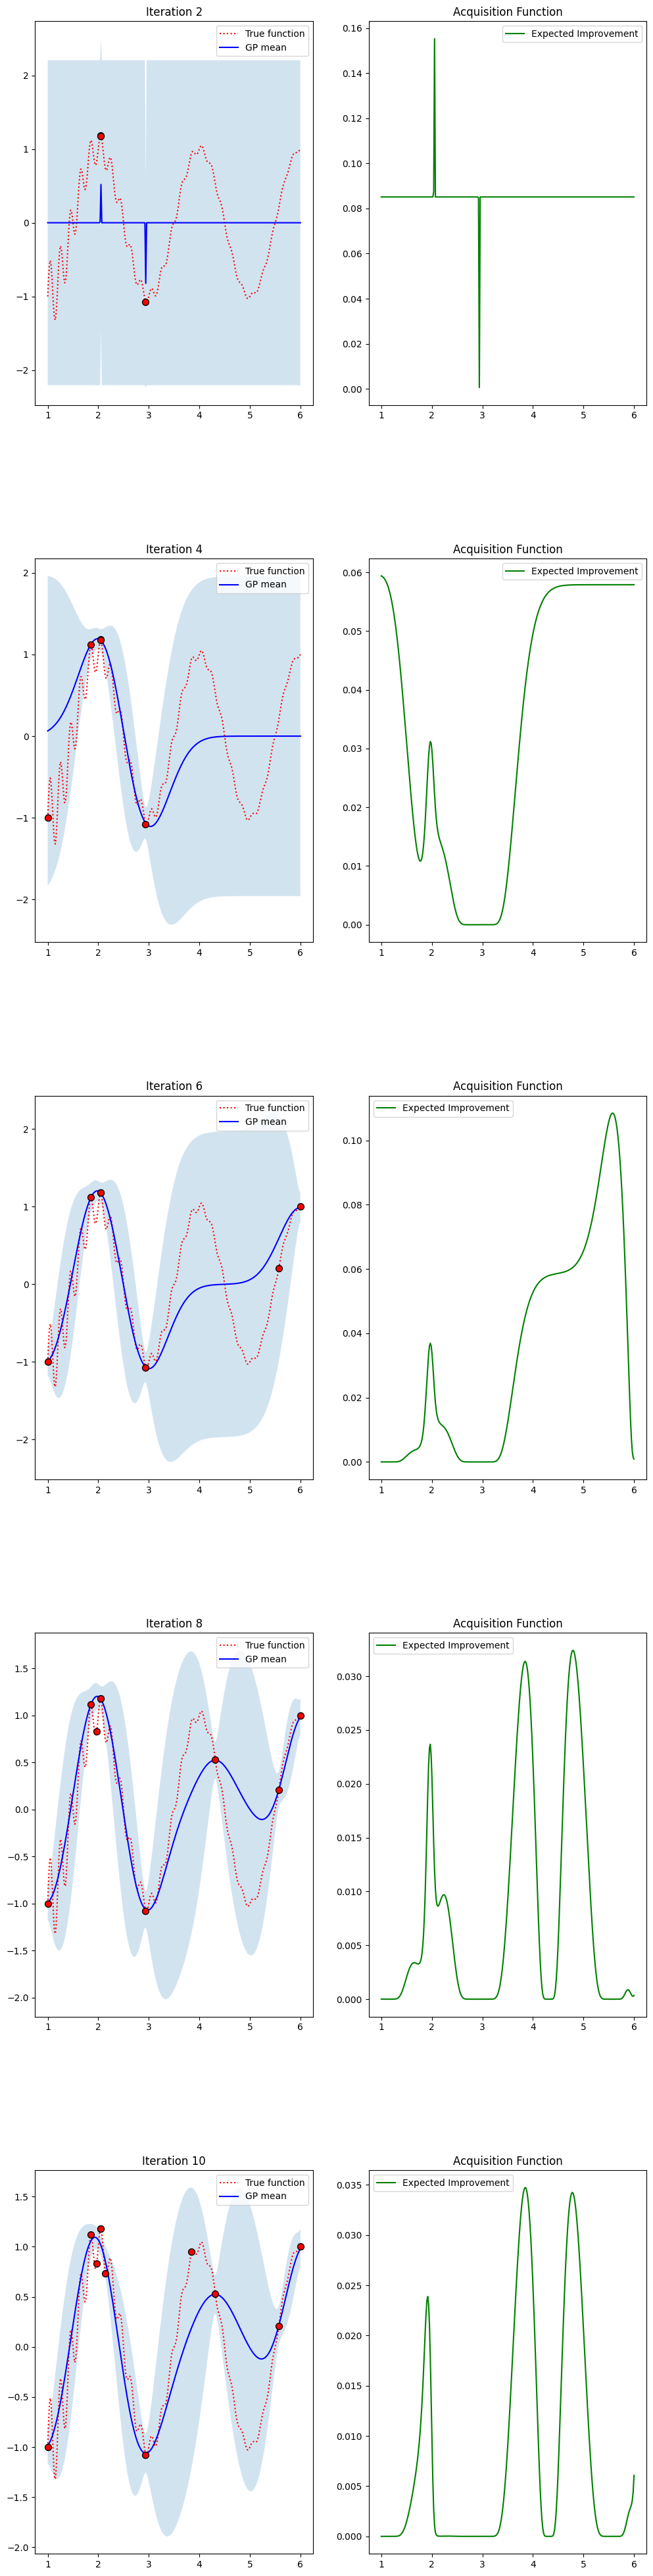

In [17]:
def f(x):
    return np.cos(x * np.pi) + np.sin(10 * np.pi * x) / (1 + x**2)

kernel = ConstantKernel(1.0) * RBF(length_scale=1.0)
noise_level = 0.1
gpr = GaussianProcessRegressor(kernel=kernel, alpha=noise_level**2)

def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample, return_std=False)
    mu_sample_opt = np.max(mu_sample)
    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    return ei

def propose_location(acquisition, X_sample, Y_sample, gpr, bounds):
    X_points = np.linspace(bounds[0], bounds[1], 1000).reshape(-1, 1)
    values = acquisition(X_points, X_sample, Y_sample, gpr)
    max_index = np.argmax(values)
    return X_points[max_index].reshape(1, -1)

a = 1
b = 6
n = 500
x = np.linspace(a, b, n)
t = f(x)

bounds = np.array([a, b])
X_init = np.random.uniform(bounds[0], bounds[1], (1, 1))
Y_init = f(X_init)

n_iter = 10
plot_interval = 2

plt.figure(figsize=(12, 5 * ((n_iter // plot_interval) * 2)))
plt.subplots_adjust(hspace=0.4)

plot_count = 0
for i in range(n_iter):
    gpr.fit(X_init, Y_init)
    X_next = propose_location(expected_improvement, X_init, Y_init, gpr, bounds)
    Y_next = f(X_next)

    X_init = np.vstack((X_init, X_next))
    Y_init = np.vstack((Y_init, Y_next))

    if (i + 1) % plot_interval == 0:
        plt.subplot((n_iter // plot_interval), 2, 2 * plot_count + 1)
        X_range = np.linspace(bounds[0], bounds[1], 300).reshape(-1, 1)
        Y_true = f(X_range)
        Y_pred, sigma = gpr.predict(X_range, return_std=True)
        plt.plot(X_range, Y_true, 'r:', label='True function')
        plt.plot(X_range, Y_pred, 'b-', label='GP mean')
        plt.fill_between(X_range[:, 0], Y_pred - 1.96 * sigma, Y_pred + 1.96 * sigma, alpha=0.2)
        plt.scatter(X_init[:, 0], Y_init, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
        plt.title(f'Iteration {i+1}')
        plt.legend()

        plt.subplot((n_iter // plot_interval), 2, 2 * plot_count + 2)
        EI = expected_improvement(X_range, X_init, Y_init, gpr)
        plt.plot(X_range, EI, 'g-', label='Expected Improvement')
        plt.title('Acquisition Function')
        plt.legend()
        plot_count += 1

plt.show()
